# This is my jam Project
## Description 
NEED TO DESCRIBE THE DATASET.

The initial research questions was initially the following:
(1) The project will study the properties of the network built on top of the ”follow” links between users. It will put these properties in perspective with the spread of Jam over time in the network;
(2) Considering the features provided by the dataset and possibly supplementary informations provided by the Spotify API, another network explaining at best the spreading of jams over itself will be built. It will be also studied with spectral graph theory;
(3) Based on the knowledge of the dataset acquired during the analysis of both graphs, a recommender system for users of the network will be built based on graph theory.

However the final result of this project is different. First the study of the spread of Jams started but quickly it has been shown that the greatest number of Jam of a song was very little in comparison with the size of the social network. Although this happenned sufficiently soon during the projet some signal analysis has been tried with these data. Primary analysis of Jams spread over networks is presented in the Data Exploration part. 

Afterward Spotify API has been used to collect more information about the songs shared, thanks to that it was possible to define a new research question. This question is related to genre of music shared by people over the  social network. More precisely the purpose of the analysis is to look for community in the graph where people tends to have similar taste in term of music genre.

Finally using the last research question analysed it has been possible to analyse a predictor of the taste of people based on graph prediction algorithms.

## Data Acquisition And Data Cleaning
In this part we first load and clean the 3 datasets provided by MyJam network. Then we complete these data with Spotify informations.

In [13]:
%matplotlib inline
#importing all relevant packages
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting
import pickle

plt.rcParams['figure.figsize'] = (10, 10)
plotting.BACKEND = 'matplotlib'

#Setting style for plotting
sns.set_style('whitegrid')
sns.set_palette('cubehelix',3)

First we need to load the data for the project. The data is stored in three tsv files:
- jams.tsc: All jams created including some matadata about the jam
- followers.tsv: Who follows who
- likes.tv: Who has liked which jams

To understand and work with this data we will load it into dataframes and do some data cleaning

In [2]:
data= pd.read_csv('jams.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

b'Skipping line 58038: expected 7 fields, saw 8\nSkipping line 58738: expected 7 fields, saw 8\n'
b'Skipping line 847113: expected 7 fields, saw 8\n'
b'Skipping line 1091137: expected 7 fields, saw 8\nSkipping line 1175359: expected 7 fields, saw 8\n'
b'Skipping line 1225919: expected 7 fields, saw 8\nSkipping line 1255341: expected 7 fields, saw 8\nSkipping line 1279655: expected 7 fields, saw 8\n'
b'Skipping line 1330659: expected 7 fields, saw 8\n'
b'Skipping line 1448017: expected 7 fields, saw 8\nSkipping line 1543877: expected 7 fields, saw 8\n'
b'Skipping line 1579553: expected 7 fields, saw 8\nSkipping line 1612432: expected 7 fields, saw 8\n'
b'Skipping line 1784572: expected 7 fields, saw 8\n'


Importing the data was only possible if we allowed for bad lines to be skipped, however we see that it is less that 20 and are not very concerned with these lines as we assume it will not make a difference in the later analysis. 

By manually inspecting the raw data it is not difficult to find lines that are being read in a wrong way In parts of the data there are newlines and \t separators that are not placed correctly. This results in empty lines and lines where the data has been shifted to either side and slip between several lines. In order to figure out how many lines are concerned with these kinds of errors we sort the dataframe on the date and thus all the lines where the format of the field creation_date is not in a date format will appear at the end. We decided to simply remove all these lines so that the ones left are the ones read correctly. It should be noted that most of the information could have been recovered by manually inspecting and removing places with faulty new lines and tabs. However, we decided that it would be too time consuming for the project. It is observed that at maximum a few 100 jams have been removed (that potentially could have been restored) and in comparison with the more than 2.000.000 jams that are part of the analysis, this is very unlikely to have any real influence on the later analysis.

Furthermore, it is observed that some song titles and artists are NaN's.This might be due to some fault in the data collection, but could also simply be because it has been possible to create jams without specifying the artist or title and therefore we leave these jams in the dataset.

We see that all jam id's are unique and that all lines contain a user id and a creaton date.

In [8]:
data = data.sort_values(by='creation_date')[0:2090068-605]

description = data.describe()
description[0:2]

,jam_id,user_id,artist,title,creation_date,link,spotify_uri
count,2089463,2089463,2088219,2089076,2089463,2072124,1479762
unique,2089463,132297,240051,568426,1492,950443,401193


The social connections (network) is described by the followint dataframe where all followers are linked to the users they follow. In this dataframe we observe no values that seem faulty.

In [5]:
net = pd.read_csv('followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
net.head(5)

,followed_user_id,follower_user_id
0,b99ebf68a8d93f024e56c65e2f949b57,1ebda3c5e05265626ab18401fb33a90a
1,c1066039fa61eede113878259c1222d1,1ebda3c5e05265626ab18401fb33a90a
2,d8a96caeef5c7d8dbdc9cec28aa9c044,1ebda3c5e05265626ab18401fb33a90a
3,2969c319775d884b860a897ba9d6156f,1ebda3c5e05265626ab18401fb33a90a
4,ff58e67948917e0ff71ba4b33e158365,1ebda3c5e05265626ab18401fb33a90a


The last dataframe contains all the likes and thus each user is linked to the jam they liked. This dataframe also seem to contain no faulty values.

In [6]:
likes = pd.read_csv('likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
likes.head()

,user_id,jam_id
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd
2,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd
3,c1066039fa61eede113878259c1222d1,4020b45a4c6d5515a3b62c489e169828
4,b99ebf68a8d93f024e56c65e2f949b57,4849f8c893a792032dbc15eb77cfd0cd


Spotify API scraping and creation of one df which contains everything needed for the data exploration about jams.

## Data Exploration

### Jams' features main properties study

### Graph properties analysis of the natural social networks (Unweighted and weighted)

#### Unweighted social network

In [9]:
followed = list(net['followed_user_id'].unique())
followers = list(net['follower_user_id'].unique())

nodes = list(set(followed+followers))

#creating the network with nodes
G = nx.Graph()
G.add_nodes_from(nodes)

#adding all edges
for i in tqdm(range(len(net))):
    if net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]:
        G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

100%|██████████| 1603404/1603404 [03:08<00:00, 8493.83it/s]


There we should put some graph properties analysis(similar to what was done in the homeworks) - closer look at the number of components etc.

Since we need to work with a connected graph for the signal processing, we chose the largest connected component.



In [10]:
nx.is_connected(G)

False

In [11]:
#Here we will keep the greatest component Gcc[0] for the further analysis
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
G = Gcc[0]

The unweigted network G has 101273 nodes.
The unweigted network G has 1294588 edges.
The nodes in G has an average degree of 25.57.


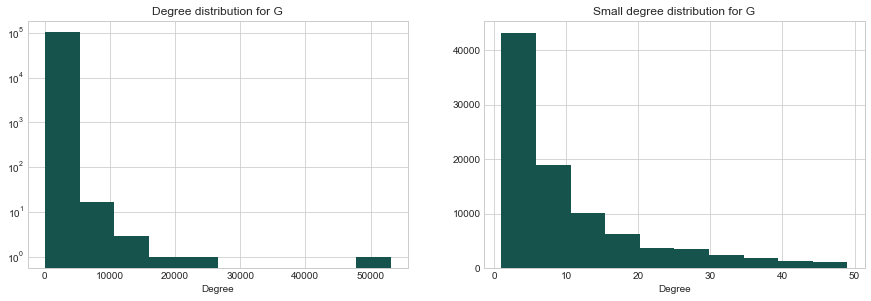

In [12]:
print('The unweigted network G has {} nodes.'.format(len(G.nodes())))
print('The unweigted network G has {} edges.'.format(G.size()))
print('The nodes in G has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G)).values()))/len(G.nodes())))

fig = plt.figure(1,figsize=(15,10))

#plotting degree distribution
degrees = np.array(list(dict(nx.degree(G)).values()))
plt.subplot(221)
plt.hist(degrees, log=True);
plt.title('Degree distribution for G');
plt.xlabel('Degree');

#plotting distribution for small degrees
small_degrees = degrees[degrees < 50]
plt.subplot(222)
plt.hist(small_degrees);
plt.title('Small degree distribution for G');
plt.xlabel('Degree');

Now we will try to detect communities in the network. If there are we will then try to analyze if communities share same music taste.

In [ ]:
comms = nx.algorithms.community.asyn_lpa_communities(G)

#### Weighted social network

In [ ]:
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')
groups = merge.groupby(['user_id_x','user_id_y']).count()
groups.sort_values(by='jam_id',ascending=False).head()

### Jams spread over time in different networks.

Put what is in the other notebook and comment on the result and the reason why we decided to change our research question.

### Genre of songs community in different networks.

In [46]:
#pickle.load('pickles/artists_ntds.pkl')
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
#artist.artist_genres.astype(str, inplace=True)
all_genre = set()
genre_graph = nx.Graph()
for genre in artist.artist_genres.values:
    all_genre = all_genre.union(set(genre))
all_genre = list(all_genre)
genre_graph = nx.Graph()
genre_graph.add_nodes_from(all_genre)
for genres in tqdm(artist.artist_genres.values):
    for i in range(len(genres)):
        for j in range(i + 1, len(genres)):
            if genre_graph.has_edge(genres[i], genres[j]):
                genre_graph[genres[i]][genres[j]]['weight'] += 1
            else:
                genre_graph.add_edge(genres[i], genres[j], weight=1)


100%|██████████| 68620/68620 [00:01<00:00, 40470.16it/s]


<class 'numpy.matrixlib.defmatrix.matrix'>
[[1836    1   27 ...,    2    4    5]]


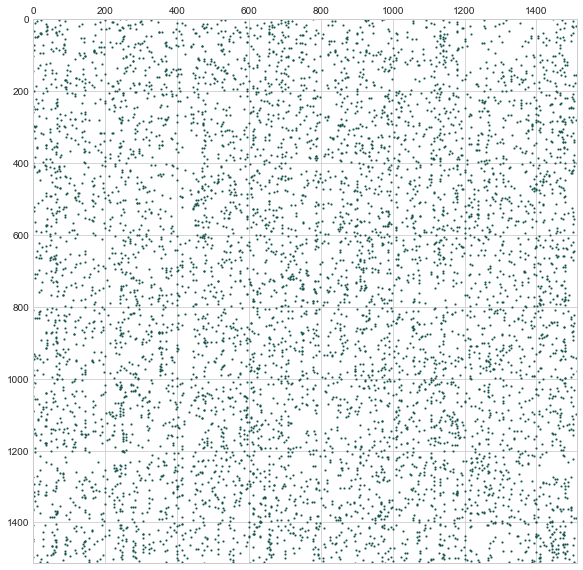

In [38]:
plt.figure(figsize=(10,10))
weights = nx.adjacency_matrix(genre_graph).todense()
print(type(weights))
NEIGHBORS = 5
# Find sorted indices for each row
sorted_row_idx = np.argsort(weights, axis=1)
for row in range(len(sorted_row_idx)):
    weights[row, sorted_row_idx[row, :-NEIGHBORS]] = 0
plt.spy(weights,markersize=1);

if np.sum(np.abs(weights-weights.transpose())) != 0:
    # Make W is symmetric
    bigger = weights.transpose() > weights
    weights = weights - weights*bigger + weights.transpose()*bigger


In [48]:
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
genre_graph = nx.Graph()
all_genres = artist.artist_genres.values

for genre in tqdm(all_genre):
    artist[genre] = 0

for i in tqdm(range(len(all_genres))):
    genres = all_genres[i]
    artist.loc[i, genres] = 1

artist.columns

100%|██████████| 68620/68620 [03:58<00:00, 287.12it/s]


Index(['artist_id', 'artist_genres', 'gangster rap', 'anime score',
       'bossa nova', 'rap metal', 'indian rock', 'spanish hip hop',
       'world meditation', 'halloween',
       ...
       'twee pop', 'russian rock', 'hip pop', 'blackgaze', 'hungarian pop',
       'kabarett', 'gothic post-punk', 'new jack swing', 'hard minimal techno',
       'hip hop'],
      dtype='object', length=1515)

In [51]:
genres_feature = artist.loc[:, artist.columns[2:]]
genre_f = genres_feature.transpose()
genre_f.head()

,0,1,2,3,4,5,6,7,8,9,...,68610,68611,68612,68613,68614,68615,68616,68617,68618,68619
gangster rap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anime score,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bossa nova,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rap metal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
indian rock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
from sklearn.cluster import KMeans
distances = []
for nb_cluster in range(1, 10):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_jobs=5).fit(genre_f)
    distances.append(kmeans.inertia_)


In [65]:
for nb_cluster in range(11, 20):
    print(nb_cluster)
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_jobs=5).fit(genre_f)
    distances.append(kmeans.inertia_)

11
12
13
14
15
16
17
18
19


[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]


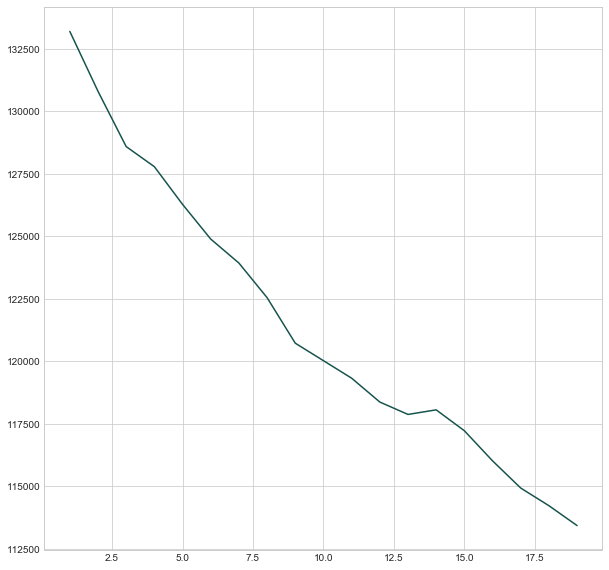

In [69]:
a = list(range(1, 10))
a += list(range(11, 20))
print(a)
plt.plot(a, distances)

## Data Exploitation

## Conclusion